In [2]:
import tarfile

In [8]:
tar = tarfile.open('aclImdb_v1.tar.gz', "r:gz")
tar.extractall()
tar.close()

In [178]:
import regex as re
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
from nltk.tokenize.toktok import ToktokTokenizer
from bs4 import BeautifulSoup # getting rid of html tags from strings (won't be necessary)
from nltk.stem import PorterStemmer # stemming the words within each review
#from nltk.stem import LancasterStemmer
import spacy
sp = spacy.load('en_core_web_sm')
from sklearn.feature_extraction.text import CountVectorizer # transfrom reviews into vectors (Bag of words)
from sklearn.feature_extraction.text import TfidfVectorizer

### Getting the data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('aclImdb')

We first get the names of all txt files

In [14]:
f_pos = os.listdir("train/pos")
f_neg = os.listdir("train/neg")

Now, let's retrieve all reviews of the training set

In [15]:

def retrieve(path, names) :
    y = []
    for l in names :
        with open(os.path.join(path, l), encoding="utf8") as x:
            y += x.readlines()
    return y

'''
train_reviews_pos = []
for l in f_pos :
    with open(os.path.join("train/pos", l), encoding="utf8") as x:
        train_reviews_pos += x.readlines()

train_reviews_neg = []
for l in f_neg :
    with open(os.path.join("train/neg", l), encoding="utf8") as x:
        train_reviews_neg += x.readlines()
'''
train_reviews_pos = retrieve("train/pos", f_pos)
train_reviews_neg = retrieve("train/neg", f_neg)

Our training set :

In [16]:
sentiments = np.concatenate((np.ones(12500), np.zeros(12500)))
sentiments = np.vectorize({0:'negative', 1:'positive'}.get)(sentiments)

data = pd.DataFrame(np.array([train_reviews_pos+train_reviews_neg, sentiments]).T
                    , columns=['reviews', 'sentiment'])
data = data.sample(frac=1).reset_index(drop=True)
data.shape

(25000, 2)

In [19]:
data.head()

,reviews,sentiment
0,I liked it but then I think I might have been ...,negative
1,Mr. Mike was probably the most misanthropic co...,negative
2,This is what I was expecting when star trek DS...,positive
3,'Intervention' has helped me with my own addic...,positive
4,Great acting on the part of Gretchen Mol. This...,positive


Our test set :

In [17]:
f_pos_test = os.listdir("test/pos")
f_neg_test = os.listdir("test/neg")
test_reviews_pos = retrieve("test/pos", f_pos_test)
test_reviews_neg = retrieve("test/neg", f_neg_test)

sentiments = np.concatenate((np.ones(12500), np.zeros(12500)))
sentiments = np.vectorize({0:'negative', 1:'positive'}.get)(sentiments)

data_test = pd.DataFrame(np.array([test_reviews_pos+test_reviews_neg, sentiments]).T
                    , columns=['reviews', 'sentiment'])
data_test = data_test.sample(frac=1).reset_index(drop=True)
data_test.shape

(25000, 2)

In [18]:
data_test.head()

,reviews,sentiment
0,"American-made final entry in the ""Blood Island...",positive
1,Sorry this was a woeful excuse for a film.. a ...,negative
2,"""The Apartment Complex"" is a campy comedy full...",negative
3,I saw this movie at the Philadelphia Film Fest...,positive
4,This movie is one of the worst movies I have e...,negative


In [22]:
broom = re.compile('<.*?>') 
def clean_html(raw_text):
    clean_text = re.sub(broom, '', raw_text)
    return clean_text

data['reviews'] = data['reviews'].apply(clean_html)
data_test['reviews'] = data_test['reviews'].apply(clean_html)

In [37]:
data.to_csv(r'data train preprep.csv')
data_test.to_csv(r'data test preprep.csv')

### Processing the data

In [10]:
# clean reviews from html tags

broom = re.compile('<.*?>') 
def clean_html(raw_text):
    clean_text = re.sub(broom, '', raw_text)
    return clean_text

# Stemming the words within each review
thing = re.compile(r'(\w)\1*')
match_sub = r'\1'
def stem(text):
    text = thing.sub(match_sub, text)
    doc = sp(text)
    # ps=nltk.porter.PorterStemmer()
    # text= ' '.join([ps.stem(word) for word in text.split()]) # don't like the result yielded by this one
    text = ' '.join([token.lemma_ for token in doc if len(token.lemma_)>1])
    return text

##
stop_words = stopwords.words('english')
tokenizer = ToktokTokenizer()

# removing the stopwords

def remove_stopwords(text):
    tokens = [token.strip() for token in tokenizer.tokenize(text)]
    filtered_tokens = [token.lower() for token in tokens if token.lower() not in stop_words]
    filtered_text = ' '.join(filtered_tokens)
    # remove rubbish
    broom = re.compile('[^A-Za-z ]')
    filtered_text = ' '.join([x.strip() for x in tokenizer.tokenize(re.sub(broom, '', filtered_text))])
    return filtered_text


def process(data) :
    data['reviews'] = data['reviews'].apply(clean_html)
    data['reviews'] = data['reviews'].apply(stem)
    data['reviews'] = data['reviews'].apply(remove_stopwords)
    return data

In [11]:
data = process(data)
data_test = process(data_test)

In [104]:
data.to_excel(r'data train.xlsx')
data_test.to_excel(r'data test.xlsx')

In [9]:
data = pd.read_excel('data train.xlsx')
data_test = pd.read_excel('data test.xlsx')

### Data treatment

#### Bag of words

The bag of words model is a way to represent text data so that it can be processed by Machine Learning models. During the processing of the data, and to ensure an optimal representation, certain techniques are usually applied :
- Ignoring case
- Ignoring punctuation
- Ignoring frequent words that don’t contain much information, called stop words, like “a,” “of,” etc.
- Fixing misspelled words
- Reducing words to their stem (e.g. “play” from “playing”) using stemming algorithms

In [10]:
# count vectorizer for bag of words
cv = CountVectorizer(min_df=0, max_df=1)

# transformed train reviews
cv_train_reviews = cv.fit_transform(data.reviews)

# transformed test reviews
cv_test_reviews = cv.transform(data_test.reviews)

print('Bag of words for cv_train:', cv_train_reviews.shape) # these are sparse matrices
print('Bag of words for cv_test:', cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

Bag of words for cv_train: (25000, 28720)
Bag of words for cv_test: (25000, 28720)


#### Tf-idf = Term Frequency (TF) * Inverse Document Frequency (IDF)

In [11]:
# tfidf vectorizer
vect = TfidfVectorizer(min_df=0, max_df=1)

# transformed train reviews
vect_train_reviews = vect.fit_transform(data.reviews)

# transformed test reviews
vect_test_reviews = vect.transform(data_test.reviews)

# returns a list of words
words = vect.get_feature_names_out()

print('Tfidf_train :', vect_train_reviews.shape)
print('Tfidf_test :', vect_test_reviews.shape)

Tfidf_train : (25000, 28720)
Tfidf_test : (25000, 28720)


In [73]:
from sklearn.preprocessing import LabelBinarizer
?LabelBinarizer

## Modelisation

### Clustering

In [ ]:
from sklearn.cluster import KMeans

In [18]:
# setup kmeans clustering
kmeans = KMeans(n_clusters = 10, n_init = 10, tol = 0.01, max_iter = 300)
kmeans.fit(vect_train_reviews)

KMeans(n_clusters=10, tol=0.01)

In [32]:
sse = []
for k in range(1, 50):
    kmeans = KMeans(n_clusters = k, n_init = 3, tol = 0.001, max_iter = 300)
    kmeans.fit(vect_train_reviews)
    sse.append(kmeans.inertia_)

Text(0, 0.5, 'SSE')

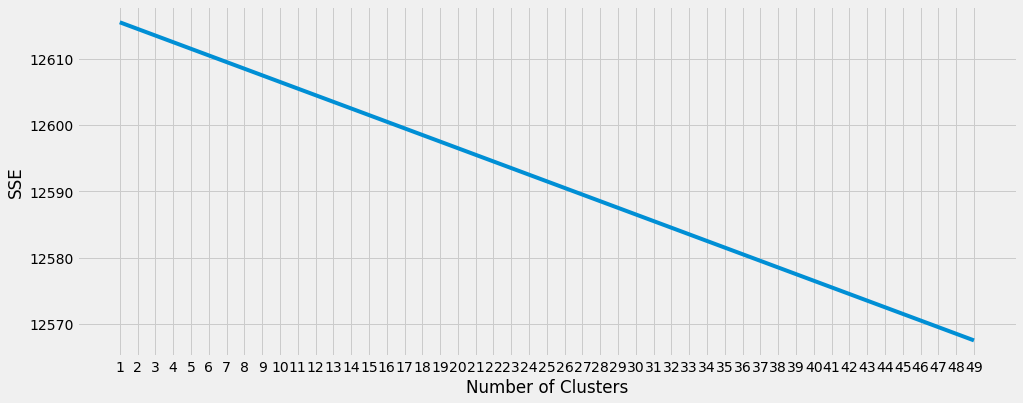

In [39]:
plt.figure(figsize=(15, 6))

plt.style.use("fivethirtyeight")
plt.plot(range(1, 50), sse)
plt.xticks(range(1, 50))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")

In [16]:
#this loop transforms the numbers back into words
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : zyuranger, mindfe, slekly, faceful, slepwalking, carfuly, carfax, sleves, sleze, facene
1 : perc, instrumentalist, cinders, mowbrays, gair, gails, gaily, gaimans, gainfuly, gaining
2 : galey, tholomyes, musain, champmathieu, frederich, bamatabois, skiping, myriel, gainfuly, gainsborough
3 : isings, zyuranger, gaionsbourg, gaijin, gailardian, gails, gaily, gaimans, gainfuly, gaining
4 : widoes, dogbery, rylance, gadabout, gaionsbourg, gaijin, gailardian, gails, gaily, gaimans
5 : crom, celticism, cruic, gailardian, gails, gaily, gaimans, gainfuly, gaining, gainsay
6 : consequences, wizs, zyuranger, gaionsbourg, gaijin, gailardian, gails, gaily, gaimans, gainfuly
7 : observationtwenty, minieapolis, ideas, zyuranger, gair, gails, gaily, gaimans, gainfuly, gaining
8 : chechens, zyuranger, gair, gailardian, gails, gaily, gaimans, gainfuly, gaining, gainsay
9 : unesential, zyuranger, gaionsbourg, gaijin, gailardian, gails, gaily, gaimans, gainfuly, gaining
10 : alp, informaly, mopey, glo

### Binary classification

We'll be fitting different models, and also see how tf-idf improves prediction compared with the output of the bag of words method

In [12]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

#### Logistic Regression

In [13]:
# training the model
reg = LogisticRegression(penalty='l2', max_iter=500, C=1, random_state=0)

# fitting the model for bag of words features
reg_bow = reg.fit(cv_train_reviews, data.sentiment)
print(reg_bow)

# fitting the model for tfidf features
reg_tfidf = reg.fit(vect_train_reviews, data.sentiment)
print(reg_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=0)
LogisticRegression(C=1, max_iter=500, random_state=0)


In [14]:
# predict sentiments for each review
reg_tfidf_predict = reg.predict(vect_train_reviews)
reg_bow_predict = reg.predict(cv_train_reviews)
print(reg_tfidf_predict)
print(reg_bow_predict)

['positive' 'positive' 'positive' ... 'positive' 'positive' 'negative']
['positive' 'positive' 'positive' ... 'positive' 'positive' 'negative']


In [15]:
# accuracy score for bag of words features
reg_bow_score = accuracy_score(data.sentiment, reg_bow_predict)
print("reg_bow_score :", reg_bow_score)

# accuracy score for tfidf features
reg_tfidf_score = accuracy_score(data.sentiment, reg_tfidf_predict)
print("reg_tfidf_score :", reg_tfidf_score)

reg_bow_score : 0.7548
reg_tfidf_score : 0.7548


In [16]:
cm_bow_train = confusion_matrix(data.sentiment, reg_bow_predict)
cm_tfidf_train = confusion_matrix(data.sentiment, reg_tfidf_predict)
print(cm_bow_train)
print(cm_tfidf_train)

[[ 6370  6130]
 [    0 12500]]
[[ 6370  6130]
 [    0 12500]]


In [17]:
reg_tfidf_predict_test = reg.predict(vect_test_reviews)
reg_bow_predict_test = reg.predict(cv_test_reviews)

# accuracy score for bag of words features on test set
reg_bow_score_test = accuracy_score(data_test.sentiment, reg_bow_predict_test)
print("reg_bow_score_test :", reg_bow_score_test)

# accuracy score for tfidf features on test set
reg_tfidf_score_test = accuracy_score(data_test.sentiment, reg_tfidf_predict_test)
print("reg_tfidf_score_test :", reg_tfidf_score_test)

reg_bow_score_test : 0.50728
reg_tfidf_score_test : 0.50724


In [18]:
cm_bow_test = confusion_matrix(data_test.sentiment, reg_bow_predict_test)
cm_tfidf_test = confusion_matrix(data_test.sentiment, reg_tfidf_predict_test)
print(cm_bow_test)
print(cm_tfidf_test)

[[ 2618  9882]
 [ 2436 10064]]
[[ 2615  9885]
 [ 2434 10066]]


#### SVM

In [19]:
# training the linear svm
svm = SGDClassifier(loss='hinge', max_iter=500, random_state=0)

# fitting the svm for bag of words features
svm_bow = svm.fit(cv_train_reviews, data.sentiment)
print(svm_bow)

# fitting the svm for tfidf features
svm_tfidf = svm.fit(vect_train_reviews, data.sentiment)
print(svm_tfidf)

SGDClassifier(max_iter=500, random_state=0)
SGDClassifier(max_iter=500, random_state=0)


In [20]:
# predict sentiments for each review
svm_bow_predict = svm.predict(vect_train_reviews)
svm_tfidf_predict = svm.predict(cv_train_reviews)
print(svm_bow_predict)
print(svm_tfidf_predict)

['negative' 'positive' 'positive' ... 'negative' 'negative' 'negative']
['negative' 'positive' 'positive' ... 'negative' 'negative' 'negative']


In [21]:
# accuracy score for bag of words features
svm_bow_score = accuracy_score(data.sentiment, svm_bow_predict)
print("svm_bow_score :", svm_bow_score)

# accuracy score for tfidf features
svm_tfidf_score = accuracy_score(data.sentiment, svm_tfidf_predict)
print("svm_tfidf_score :", svm_tfidf_score)

svm_bow_score : 0.74984
svm_tfidf_score : 0.74984


In [22]:
svm_tfidf_predict_test = svm.predict(vect_test_reviews)
svm_bow_predict_test = svm.predict(cv_test_reviews)

# accuracy score for bag of words features on test set
svm_bow_score_test = accuracy_score(data_test.sentiment, svm_bow_predict_test)
print("svm_bow_score_test :", svm_bow_score_test)

# accuracy score for tfidf features on test set
svm_tfidf_score_test = accuracy_score(data_test.sentiment, svm_tfidf_predict_test)
print("svm_tfidf_score_test :", svm_tfidf_score_test)

svm_bow_score_test : 0.5214
svm_tfidf_score_test : 0.5216


### LSTM

As we can see with the previously used methods, the results aren't quite satisfactory. In fact, the accuracy of the models on the test set are barely better that random guessing. The issue might be in the preprocessing step which we'll go back into, but for now, let's see if using neural networks manage to improve the accuracy.

In [144]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding, Flatten

In [185]:
data = pd.read_excel('data train.xlsx')
data_test = pd.read_excel('data test.xlsx')

In [116]:
data = pd.read_csv('data train preprep.csv', index_col=0)
data_test = pd.read_csv('data test preprep.csv', index_col=0)
def lll(x):
    if x=='negative' : 
        return 0
    return 1

In [186]:
def preproc(data) :    
    # tokenizing
    reviews = data.reviews.values
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(reviews)
    encoded_reviews = tokenizer.texts_to_sequences(reviews)

    # padding
    padded_reviews = pad_sequences(encoded_reviews)
    return padded_reviews

padded_reviews = preproc(data) # shape : (25000, 1414)
padded_reviews_test = preproc(data_test)

In [ ]:
padded_reviews.reshape(25000, 1414, 1)

In [190]:
number_of_distinct_words = 1414
vocab_size = 65065

# fitting the LSTM

model = Sequential()
model.add(Embedding(vocab_size , output_dim = 32, input_length = number_of_distinct_words))
#model.add(SpatialDropout1D(0.25))
model.add(LSTM(5, dropout=0.5, recurrent_dropout=0.5, batch_input_shape=(25000, 1414, 1), return_sequences=True))
#model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [ ]:
mod = model.fit(padded_reviews.reshape(25000, 1414, 1), np.array(data.sentiment.map(lll)), 
                validation_data=(padded_reviews_test, np.array(data_test.sentiment.map(lll))), 
                epochs=5)